(1929, 1)
(1929, 1)
(1929, 1)
(1929, 1)
(1929,)
Number of parameters:  491
Epoch 200 Train 52.82339 Valid 147.87927
Epoch 400 Train 4.57302 Valid 10.43380
Epoch 600 Train 3.21644 Valid 2.23928
Epoch 800 Train 2.30845 Valid 1.89019
Epoch 1000 Train 2.07474 Valid 1.72057
Epoch 1200 Train 1.86451 Valid 2.15218
Epoch 1400 Train 1.63260 Valid 1.58932
Epoch 1600 Train 1.64053 Valid 1.54793
Epoch 1800 Train 1.65425 Valid 1.55794
Epoch 2000 Train 1.56941 Valid 1.54759
Epoch 2200 Train 1.58374 Valid 1.54243
Epoch 2400 Train 1.52523 Valid 1.53399
Epoch 2600 Train 1.60686 Valid 1.53552
Epoch 2800 Train 1.51471 Valid 1.53258
Epoch 3000 Train 1.61198 Valid 1.53228
Epoch 3200 Train 1.63235 Valid 1.53257
Epoch 3400 Train 1.58201 Valid 1.53272
Epoch 3600 Train 1.50175 Valid 1.53236
Epoch 3800 Train 1.50279 Valid 1.53241
Training finished! Model is saved!
Test Loss: 0.07236
Relative Error: 5.57156907
RMS Error: 7.18414403
MAX Error: 28.63399040


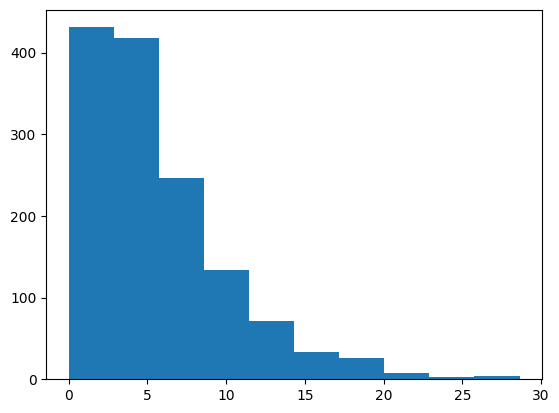

In [ ]:

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math
import matplotlib.pyplot as plt
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define a fully connected layers model with three inputs (frequency, flux density, duty ratio) and one output (core loss).
        self.layers = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        return self.layers(x)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_dataset():
    # Load .json Files
    with open('/content/Dataset_tri_3E6.json','r') as load_f:
        DATA = json.load(load_f)

    Freq = DATA['Frequency']
    Flux = DATA['Flux_Density']
    Duty = DATA['Duty_Ratio']
    Temperature = DATA['Temperature']
    Power = DATA['Power_Loss']

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq = np.log10(Freq)
    Flux = np.log10(Flux)
    Duty = np.array(Duty)
    Temperature = np.array(Temperature)
    Power = np.log10(Power)

    # Reshape data
    Freq = Freq.reshape((-1,1))
    Flux = Flux.reshape((-1,1))
    Duty = Duty.reshape((-1,1))
    Temperature = Temperature.reshape((-1,1))

    print(np.shape(Freq))
    print(np.shape(Flux))
    print(np.shape(Duty))
    print(np.shape(Temperature))
    print(np.shape(Power))

    temp = np.concatenate((Freq, Flux, Duty, Temperature),axis=1)

    in_tensors = torch.from_numpy(temp).view(-1, 4)
    out_tensors = torch.from_numpy(Power).view(-1, 1)

    # # Save dataset for future use
    # np.save("dataset.fc.in.npy", in_tensors.numpy())
    # np.save("dataset.fc.out.npy", out_tensors.numpy())

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)

def get_test():

    with open('/content/Dataset_tri_3E6_pretest.json','r') as load_test:
        DATA_TEST = json.load(load_test)


    Freq_t = DATA_TEST['Frequency']
    Flux_t = DATA_TEST['Flux_Density']
    Duty_t = DATA_TEST['Duty_Ratio']
    Temperature_t = DATA_TEST['Temperature']
    Power_t = DATA_TEST['Power_Loss']

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq_t = np.log10(Freq_t)
    Flux_t = np.log10(Flux_t)
    Duty_t = np.array(Duty_t)
    Temperature_t = np.array(Temperature_t)
    Power_t = np.log10(Power_t)

    # Reshape data
    Freq_t = Freq_t.reshape((-1,1))
    Flux_t = Flux_t.reshape((-1,1))
    Duty_t = Duty_t.reshape((-1,1))
    Temperature_t = Temperature_t.reshape((-1,1))

    tmp = np.concatenate((Freq_t, Flux_t, Duty_t, Temperature_t),axis=1)

    in_tensors = torch.from_numpy(tmp).view(-1, 4)
    out_tensors = torch.from_numpy(Power_t).view(-1, 1)

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)


def main():
    # Reproducibility
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    NUM_EPOCH = 3800
    BATCH_SIZE = 64
    DECAY_EPOCH = 150
    DECAY_RATIO = 0.6
    LR_INI = 0.02

    # Select GPU as default device
    device = torch.device("cuda")

    # Load dataset
    dataset = get_dataset()

    testing = get_test()

    # Split the dataset
    train_size = int(0.7 * len(dataset))
    valid_size = len(dataset)-train_size
    test_size = int(len(testing))
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    test_dataset = testing
    kwargs = {'num_workers': 0, 'pin_memory': True, 'pin_memory_device': "cuda"}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

    # Setup network
    net = Net().double().to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Setup optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=LR_INI)

    # Train the network
    for epoch_i in range(NUM_EPOCH):

        # Train for one epoch
        epoch_train_loss = 0
        net.train()
        optimizer.param_groups[0]['lr'] = LR_INI* (DECAY_RATIO ** (0+ epoch_i // DECAY_EPOCH))

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Compute Validation Loss
        with torch.no_grad():
            epoch_valid_loss = 0
            for inputs, labels in valid_loader:
                outputs = net(inputs.to(device))
                loss = criterion(outputs, labels.to(device))

                epoch_valid_loss += loss.item()

        if (epoch_i+1)%200 == 0:
          print(f"Epoch {epoch_i+1:2d} "
              f"Train {epoch_train_loss / len(train_dataset) * 1e5:.5f} "
              f"Valid {epoch_valid_loss / len(valid_dataset) * 1e5:.5f}")

    # Save the model parameters
    torch.save(net.state_dict(), "/content/Model_FNN_3E6.sd")
    print("Training finished! Model is saved!")

    # Evaluation
    net.eval()
    y_meas = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            y_pred.append(net(inputs.to(device)))
            y_meas.append(labels.to(device))

    y_meas = torch.cat(y_meas, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print(f"Test Loss: {F.mse_loss(y_meas, y_pred).item() / len(test_dataset) * 1e5:.5f}")

    yy_pred = 10**(y_pred.cpu().numpy())
    yy_meas = 10**(y_meas.cpu().numpy())

    # Relative Error
    Error_re = abs(yy_pred-yy_meas)/abs(yy_meas)*100
    Error_re_avg = np.mean(Error_re)
    Error_re_rms = np.sqrt(np.mean(Error_re ** 2))
    Error_re_max = np.max(Error_re)
    print(f"Relative Error: {Error_re_avg:.8f}")
    print(f"RMS Error: {Error_re_rms:.8f}")
    print(f"MAX Error: {Error_re_max:.8f}")
    plt.hist(Error_re)
    plt.show()

if __name__ == "__main__":
    main()
